In [1]:
import numpy as np

In [6]:
from mlcolvar.data.graph.utils import create_test_graph_input

sss = create_test_graph_input(output_type='datamodule', n_samples=3, n_states=2)
sss

DictModule(dataset -> DictDataset( "data_list": 6, "z_table": [1, 8], "cutoff": 0.1, "data_type": graphs ),
		     train_loader -> DictLoader(length=1.0, batch_size=6, shuffle=False))

In [3]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_trajectories
from mlcolvar.utils.io import create_dataset_from_files


dataset_graph = create_dataset_from_trajectories(
    trajectories=[
        'data/r.dcd',
        'data/p.dcd'
    ],
    top=['data/r.pdb', 
         'data/p.pdb'],
    cutoff=8.0,  # Ang
    create_labels=True,
    system_selection='all and not type H',
    show_progress=False
)

datamodule_graph = DictModule(dataset_graph, lengths=[0.8, 0.2])
print(datamodule_graph)


dataset_ff = create_dataset_from_files(file_names=['data/colvar_r.dat',
                                                   'data/colvar_p.dat'],
                                                   filter_args={'regex': 'd'})

datamodule_ff = DictModule(dataset_ff, lengths=[0.8, 0.2])


DictModule(dataset -> DictDataset( "data_list": 1600, "z_table": [6, 9], "cutoff": 8.0, "data_type": graphs ),
		     train_loader -> DictLoader(length=0.8, batch_size=1600, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=1600, shuffle=True))
Class 0 dataframe shape:  (800, 24)
Class 1 dataframe shape:  (800, 24)

 - Loaded dataframe (1600, 24): ['time', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'walker', 'labels']
 - Descriptors (1600, 21): ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21']


In [4]:
from mlcolvar.core.nn.graph.schnet import SchNetModel

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset_graph.metadata['cutoff'],
                        atomic_numbers=dataset_graph.metadata['z_table'],
                        n_bases=6,
                        n_layers=2,
                        n_filters=32,
                        n_hidden_channels=32
                    )

In [20]:
n_samples=10
n_states=3
n_atoms = 3
numbers = [8, 1, 1]
_ref_positions = np.array(
    [
        [[0.0, 0.0, 0.0], [0.07, 0.07, 0.0], [0.07, -0.07, 0.0]],
        [[0.0, 0.0, 0.0], [-0.07, 0.07, 0.0], [0.07, 0.07, 0.0]],
        [[0.0, 0.0, 0.0], [0.07, -0.07, 0.0], [0.07, 0.07, 0.0]],
        [[0.0, 0.0, 0.0], [0.0, -0.07, 0.07], [0.0, 0.07, 0.07]],
        [[0.0, 0.0, 0.0], [0.07, 0.0, 0.07], [-0.07, 0.0, 0.07]],
        [[0.1, 0.0, 1.1], [0.17, 0.07, 1.1], [0.17, -0.07, 1.1]],
    ],
    dtype=np.float64
)

# positions = np.zeros((n_samples*n_states, 3, 3))
idx = np.random.randint(low=0, high=6, size=(n_samples*n_states))

positions = _ref_positions[idx, :, :]
positions.shape

graph_labels = np.array([[[0]], [[1]]] * 3)
graph_labels.shape

(6, 1, 1)

In [13]:
dataset_graph.metadata['z_table']

[6, 9]

In [5]:
from mlcolvar.cvs.supervised.deeptda_merged import DeepTDA

model_graph = DeepTDA(n_states=2,
                        n_cvs=1,
                        target_centers=[-7, 7],
                        target_sigmas=[0.2, 0.2],
                        model=gnn_model)

from mlcolvar.core.nn import FeedForward

ff_model = FeedForward(layers=[21, 15, 10, 1])
model_ff = DeepTDA(n_states=2,
                    n_cvs=1,
                    target_centers=[-7, 7],
                    target_sigmas=[0.2, 0.2],
                    model=ff_model)

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [12]:
list(ff_model.modules())

[FeedForward(
   (nn): Sequential(
     (0): Linear(in_features=21, out_features=15, bias=True)
     (1): ReLU(inplace=True)
     (2): Linear(in_features=15, out_features=10, bias=True)
     (3): ReLU(inplace=True)
     (4): Linear(in_features=10, out_features=1, bias=True)
   )
 ),
 Sequential(
   (0): Linear(in_features=21, out_features=15, bias=True)
   (1): ReLU(inplace=True)
   (2): Linear(in_features=15, out_features=10, bias=True)
   (3): ReLU(inplace=True)
   (4): Linear(in_features=10, out_features=1, bias=True)
 ),
 Linear(in_features=21, out_features=15, bias=True),
 ReLU(inplace=True),
 Linear(in_features=15, out_features=10, bias=True),
 ReLU(inplace=True),
 Linear(in_features=10, out_features=1, bias=True)]

In [21]:
from lightning import Trainer

trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='cpu',
    max_epochs=5,
    enable_model_summary=False
)

trainer.fit(model_graph, datamodule_graph)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [22]:
model_graph(sss)

tensor([[0.3194]], grad_fn=<DivBackward0>)

In [23]:
datamodule_graph.setup()
a = datamodule_graph.train_dataloader()
list(a)
test = next(iter(a))
inp = test['data_list']
inp

DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])

In [24]:
import torch
xxx = inp.get_example(0)
xxx.batch = torch.tensor([0], dtype = torch.long)
xxx

Data(edge_index=[2, 42], shifts=[42, 3], unit_shifts=[42, 3], positions=[7, 3], cell=[3, 3], node_attrs=[7, 2], graph_labels=[1, 1], n_system=[1, 1], weight=[1], batch=[1])

In [25]:
# model_graph.eval()
traced_model = model_graph.to_torchscript('test.pt', method='trace', example_inputs=sss.to_dict())

In [26]:
from mlcolvar.data.graph.utils import create_dataset_from_configurations
from mlcolvar.data.graph.atomic import AtomicNumberTable, Configuration

numbers = gnn_model.atomic_numbers.cpu().numpy().tolist()
positions = np.random.randn(2, len(numbers), 3)
cell = np.identity(3, dtype=float) * 0.2
graph_labels = np.array([[[0]], [[1]]])
node_labels = np.array([[0]] * len(numbers))
z_table = AtomicNumberTable.from_zs(numbers)

config = [
    Configuration(
        atomic_numbers=numbers,
        positions=positions[i],
        cell=cell,
        pbc=[True] * 3,
        node_labels=node_labels,
        graph_labels=graph_labels[i],
    ) for i in range(2)
]
dataset = create_dataset_from_configurations(
    config, z_table, 0.1, show_progress=False
)

loader = DictModule(
    dataset,
    lengths=(1.0,),
    batch_size=10,
    shuffle=False,
)
loader.setup()

please = next(iter(loader.train_dataloader()))
inp_test = please['data_list']

In [27]:
import torch
inp_test.batch = torch.tensor([0], dtype=torch.long)

inp_test

DataBatch(edge_index=[2, 2], shifts=[2, 3], unit_shifts=[2, 3], positions=[4, 3], cell=[6, 3], node_attrs=[4, 2], node_labels=[4, 1], graph_labels=[2, 1], n_system=[2, 1], weight=[2], batch=[1], ptr=[3])

In [28]:
print(model_graph(xxx))
print(model_graph(inp_test))

tensor([[0.4284]], grad_fn=<DivBackward0>)
tensor([[0.6660]], grad_fn=<DivBackward0>)


In [29]:
print(model_graph(xxx))
print(model_graph(inp_test))

print(traced_model(xxx))
print(traced_model(inp_test))

loaded_model = torch.jit.load('test.pt')

print(loaded_model(xxx))
print(loaded_model(inp_test))

# EVVIVAAAAAA

tensor([[0.4284]], grad_fn=<DivBackward0>)
tensor([[0.6660]], grad_fn=<DivBackward0>)
tensor([[0.4284]], grad_fn=<DivBackward0>)
tensor([[0.6660]], grad_fn=<DivBackward0>)
tensor([[0.4284]], grad_fn=<DivBackward0>)
tensor([[0.6660]], grad_fn=<DivBackward0>)


In [30]:
datamodule_ff.setup()

a = datamodule_ff.train_dataloader()
a.dataset['data']

datamodule_graph.setup()
a = datamodule_graph.train_dataloader()
list(a)


[{'data_list': DataBatch(edge_index=[2, 53760], shifts=[53760, 3], unit_shifts=[53760, 3], positions=[8960, 3], cell=[3840, 3], node_attrs=[8960, 2], graph_labels=[1280, 1], n_system=[1280, 1], weight=[1280], batch=[8960], ptr=[1281])}]

In [32]:
trainer = Trainer(
    logger=False,
    enable_checkpointing=False,
    accelerator='cpu',
    max_epochs=5,
    enable_model_summary=False
)

trainer.fit(model_ff, datamodule_ff)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [17]:
loader = datamodule_graph
test = next(iter(loader.train_dataloader()))['data_list']
out_graph = model_graph(test)

out_ff = model_ff(dataset_ff['data'])

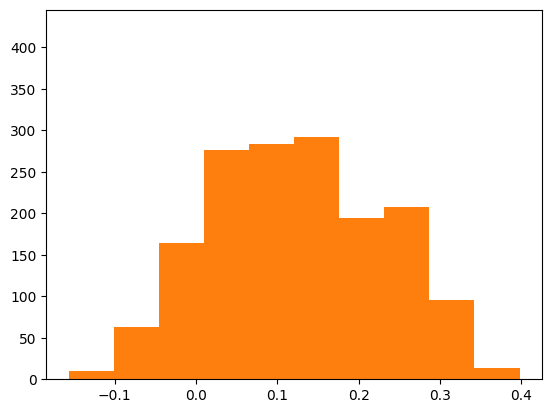

In [16]:
import matplotlib.pyplot as plt

plt.hist(out_graph.detach().squeeze())
plt.hist(out_ff.detach().squeeze())
plt.show()